# Digital Futures
# Video Game Recommendation System For Capstone Project
# By Liam Dearlove

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET
import numpy as np


from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [266]:
# Using XML web scraping from a chosen steam community page to get a large amount of varied Steam IDs
xml_url = "https://steamcommunity.com/groups/usgamingcommunity/memberslistxml/?xml=1"

response = requests.get(xml_url)

root = ET.fromstring(response.content)

id_list = []

for x in root.iter('steamID64'):
    id_list.append(int(x.text))

In [267]:
# Extending list of user ids with other available ids - Test ID for later: 76561198022981376
id_list.extend([76561198022981376, 76561198042246813, 76561198046998765, 76561198062545361, 76561198068342857, 76561198032238060, 76561198042091058])

In [268]:
# Getting id and playtime for each game owned by each id
# Set your Steam API key
api_key = "A9283666CBEBA01186FF7EB5D8F80120"

steam_ids = id_list

# List to store the dictionaries
data_list = []

# Loop through the Steam IDs
for steam_id in steam_ids:

    url = f"http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={api_key}&steamid={steam_id}&format=json"

    response = requests.get(url)

    data = json.loads(response.text)
    
    if 'games' not in data["response"]:

        print(f"Skipping {steam_id} - no games found")

        continue

    games = data["response"]['games']

    game_data = []

    for game in games:

        game_data.append({"appid": game["appid"], "playtime_forever": game["playtime_forever"]})

    dict = {'steam_id': steam_id, 'game_data': game_data}

    data_list.append(dict)

Skipping 76561198147237442 - no games found


In [269]:
# Function to get list of apps on Steam - To get name of every app
def get_app_list():
    url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
    response = requests.get(url)
    app_list = response.json()
    return app_list['applist']['apps']

In [270]:
# Code to match up names of apps with app ids in the game data for each user
x_names = get_app_list()

game_names = [game for game in x_names if 'name' in game and game['name'] != '']

appid_name_map = {game['appid']: game['name'] for game in game_names}


for x in data_list:
    for game in x['game_data']:
    
        if game['appid'] in appid_name_map:
    
            game['name'] = appid_name_map[game['appid']]


In [271]:
# Creates a dataframe with each game as a column, each row is a steam user (with their ID) and the data is the playtime for each game
# The dataframe is then ready for cleaning
df_data = []


for x in data_list:

    game_data = x['game_data']

    temp_data = {'steam_id': x['steam_id']}


    for game in game_data:

        if 'name' in game and 'playtime_forever' in game:

            temp_data[game['name']] = game['playtime_forever']

    
    df_data.append(temp_data)


df = pd.DataFrame(df_data)


df

,steam_id,Counter-Strike,Counter-Strike: Condition Zero,Counter-Strike: Condition Zero Deleted Scenes,Day of Defeat: Source,Team Fortress Classic,Day of Defeat,Deathmatch Classic,Half-Life: Opposing Force,Ricochet,...,Air Forte,Wilmot's Warehouse,Hyperspace Dogfights,Catlateral Damage: Remeowstered,Mighty Goose,Retro Gadgets,Slayers X,The Zachtronics Solitaire Collection,Ad Fundum,It's Quiz Time
0,76561198069439929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76561198031008457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,76561198062363193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198118886096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76561198137596577,4.0,0.0,0.0,221.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,76561198046998765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,76561198062545361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1194.0
1003,76561198068342857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,76561198032238060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Exploration

In [272]:
df.dtypes

steam_id                                           int64
Counter-Strike                                   float64
Counter-Strike: Condition Zero                   float64
Counter-Strike: Condition Zero Deleted Scenes    float64
Day of Defeat: Source                            float64
                                                  ...   
Retro Gadgets                                    float64
Slayers X                                        float64
The Zachtronics Solitaire Collection             float64
Ad Fundum                                        float64
It's Quiz Time                                   float64
Length: 28421, dtype: object

In [273]:
# Function to check for nulls and display as a table with both null values and as a percentage
def null_vals(dataframe):
    '''Function to show both number of nulls and the percentage of nulls in the whole column'''
    null_vals = dataframe.isnull().sum() # How many nulls in each column
    total_cnt = len(dataframe) # Total entries in the dataframe
    null_vals = pd.DataFrame(null_vals,columns=['null']) # Put the number of nulls in a single dataframe
    null_vals['percent'] = round((null_vals['null']/total_cnt)*100,3) # Round how many nulls are there, as %, of the df
    
    return null_vals.sort_values('percent', ascending=False) #Return the number and percentage of missing values, order by percentage descending

null_vals(df) #Display the table

,null,percent
It's Quiz Time,1005,99.901
Family curse,1005,99.901
Ocean Is Home : Island Life Simulator,1005,99.901
Crab God,1005,99.901
Be My Horde,1005,99.901
...,...,...
Paladins - Public Test,383,38.072
Minion Masters,279,27.734
PUBG: BATTLEGROUNDS,240,23.857
Counter-Strike 2,61,6.064


In [274]:
# Convert to different DF for easier exploration
new_df = pd.melt(df, id_vars=['steam_id'], var_name='game', value_name='playtime')

new_df = new_df.dropna(subset=['playtime'])

new_df

,steam_id,game,playtime
0,76561198069439929,Counter-Strike,0.0
1,76561198031008457,Counter-Strike,0.0
4,76561198137596577,Counter-Strike,4.0
6,76561197998401807,Counter-Strike,0.0
9,76561198125016142,Counter-Strike,0.0
...,...,...,...
28586486,76561197999086138,Retro Gadgets,8.0
28587492,76561197999086138,Slayers X,7.0
28588498,76561197999086138,The Zachtronics Solitaire Collection,1094.0
28589504,76561197999086138,Ad Fundum,17.0


In [275]:
# Checking average playtime, min and max
new_df.describe()

,steam_id,playtime
count,8.455010e+05,8.455010e+05
mean,7.656120e+16,1.343846e+03
std,3.095911e+08,3.229131e+04
min,7.656120e+16,0.000000e+00
25%,7.656120e+16,0.000000e+00
50%,7.656120e+16,0.000000e+00
75%,7.656120e+16,2.040000e+02
max,7.656120e+16,5.050143e+06


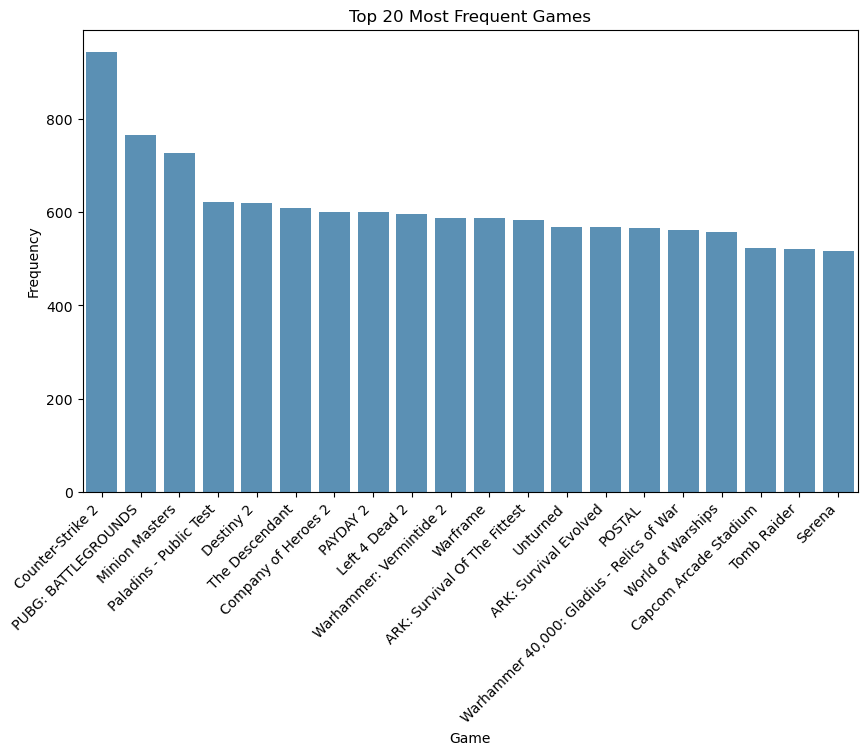

In [276]:
# Plot a graph to see the most frequent games in the users' libraries
game_counts = new_df['game'].value_counts().head(20)

plt.figure(figsize=(10, 6))

sns.barplot(x=game_counts.index, y=game_counts.values, alpha=0.8)

plt.title('Top 20 Most Frequent Games')

plt.xlabel('Game')
plt.xticks(rotation=45, ha='right')

plt.ylabel('Frequency')


plt.show()

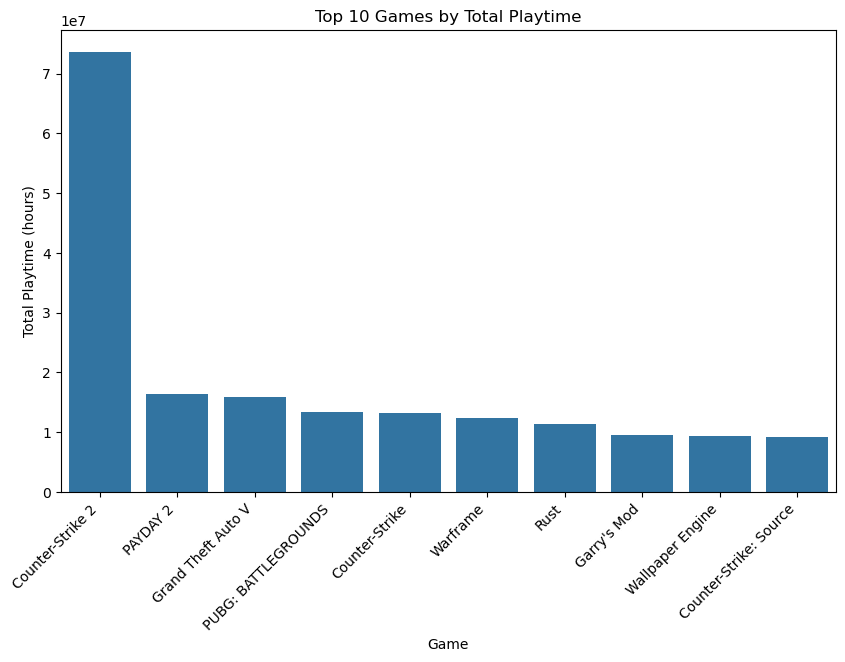

In [277]:
# Plotting a graph to the games with largest playtime
game_playtime = new_df.groupby('game')['playtime'].sum().reset_index()

game_playtime = game_playtime.sort_values('playtime', ascending=False)


plt.figure(figsize=(10, 6))

sns.barplot(x='game', y='playtime', data=game_playtime.head(10))

plt.title('Top 10 Games by Total Playtime')
plt.xlabel('Game')
plt.ylabel('Total Playtime (hours)')
plt.xticks(rotation=45, ha='right')


plt.show()

# Feature Engineering

In [278]:
def feature_eng(df):
    # Apps to be removed- Non-games
    apps_to_remove = ['Blender', 'Wallpaper Engine', 'Soundpad', 'Stream Avatars', 'Lossless Scaling', 'DisplayFusion', 'Krita', 'Crosshair X', 'Aseprite', 'SAO Utils: Beta']

    # Filter the list to only include columns that exist in the DataFrame
    existing_columns_to_remove = [col for col in apps_to_remove if col in df.columns]

    # Drop the specified columns
    df.drop(columns=existing_columns_to_remove, inplace=True)

    # Fill any NaN with 0 as users would have 0 playtime in a game they do not own
    df.fillna(0, inplace=True)

    # Setting steam user id as index
    #df.set_index('steam_id', inplace=True)



feature_eng(df)

In [279]:
# Recreate this DF with feature engineering done
new_df = pd.melt(df, id_vars=['steam_id'], var_name='game', value_name='playtime')

new_df = new_df.dropna(subset=['playtime'])

new_df

,steam_id,game,playtime
0,76561198069439929,Counter-Strike,0.0
1,76561198031008457,Counter-Strike,0.0
2,76561198062363193,Counter-Strike,0.0
3,76561198118886096,Counter-Strike,0.0
4,76561198137596577,Counter-Strike,4.0
...,...,...,...
28580455,76561198046998765,It's Quiz Time,0.0
28580456,76561198062545361,It's Quiz Time,1194.0
28580457,76561198068342857,It's Quiz Time,0.0
28580458,76561198032238060,It's Quiz Time,0.0


In [280]:
# Once feature engineering done on original df, will have to convert other DF again so then be (potentially) filtered and then converted to matrix for use in models

# Content-based Filtering

In [281]:
# Get top 500 unique games by playtime
aggregated_games = new_df.groupby('game', as_index=False)['playtime'].sum()
top_500_games = aggregated_games.sort_values(by='playtime', ascending=False).head(500)


In [282]:
# Adding game id to the top 500 games
game_ids_df = pd.DataFrame(game_names)

top_500_games_with_ids = top_500_games.merge(game_ids_df, left_on='game', right_on='name', how='left')


In [283]:
# Dropping duplicates as some games have multiple ids
top_500_unique_games_without_duplicates = top_500_games_with_ids.drop_duplicates(subset='game')


In [284]:
def get_app_details(app_id):
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json().get(str(app_id), {}).get('data', {})
        if data:
            genres = [genre['description'] for genre in data.get('genres', [])]
            print(genres)
            return ', '.join(genres) if genres else None
    return None



In [287]:
top_500_unique_games_without_duplicates.loc[:, 'genres'] = top_500_unique_games_without_duplicates['appid'].apply(get_app_details)

['Action', 'Free to Play']
['Action', 'RPG']
['Action', 'Adventure', 'Massively Multiplayer', 'Free to Play']
['Action']
['Action', 'RPG', 'Free to Play']
['Movie']
['Casual', 'Indie', 'Simulation']
['Action']
['Action', 'Adventure', 'Casual', 'Indie', 'Free to Play']
['Action']
['Action']
['Action', 'Adventure', 'Free to Play']
['Strategy']
['Indie', 'Simulation']
['Adventure', 'Casual', 'Massively Multiplayer', 'Simulation', 'Sports', 'Free to Play', 'Early Access']
['Action']
['Action', 'Adventure', 'Indie', 'RPG', 'Simulation', 'Strategy', 'Early Access']
['Action', 'Adventure', 'Indie', 'RPG', 'Simulation', 'Strategy']
['Action', 'Adventure', 'Free to Play']
['Casual', 'Free to Play', 'Indie']
['Action', 'Adventure', 'Indie', 'Massively Multiplayer', 'RPG', 'Free to Play']
['Strategy']
['Action', 'Adventure', 'Indie', 'RPG']
['Action', 'Massively Multiplayer', 'Simulation', 'Free to Play']
['Adventure', 'Casual', 'Indie', 'RPG', 'Simulation', 'Strategy', 'Free to Play']
['Casual',

/var/folders/md/qszqkzy929909bzx2dgdwr_h0000gn/T/ipykernel_42203/173935848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_500_unique_games_without_duplicates.loc[:, 'genres'] = top_500_unique_games_without_duplicates['appid'].apply(get_app_details)


## Finding out what the top 10 genres in the top 500 games by playtime are!

In [288]:
new_rows = []
for index, row in top_500_unique_games_without_duplicates.iterrows():
    game = row['game']
    genres = row['genres']
    
    # Skip rows where genres is None
    if pd.isna(genres):
        continue
    
    for genre in genres.split(', '):
        new_rows.append({'game': game, 'genre': genre})

genre_sep_df = pd.DataFrame(new_rows)


genre
Action                   146
Adventure                 96
Indie                     93
Free to Play              74
RPG                       69
Casual                    58
Simulation                58
Strategy                  53
Massively Multiplayer     38
Early Access              12
Name: count, dtype: int64


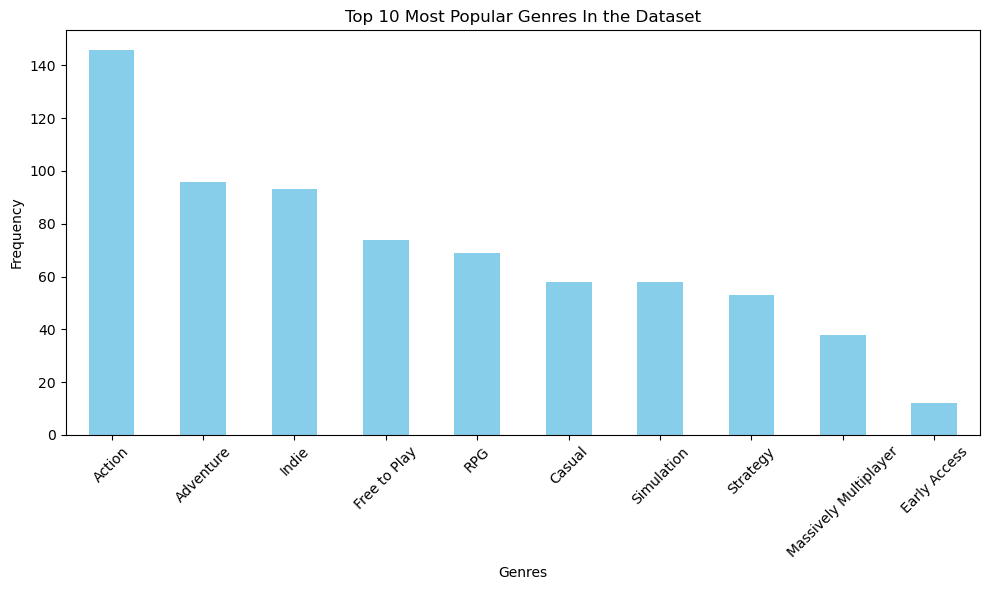

In [289]:
genre_counts = genre_sep_df['genre'].value_counts()

sorted_genres = genre_counts.sort_values(ascending=False)

print(sorted_genres.head(10))

plt.figure(figsize=(10, 6))
sorted_genres.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Popular Genres In the Dataset')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

############################################################--------------------------------––########################################

# Content Based Recommendations Based On Genre

In [290]:
genres_list = [
    'Action', 'Indie', 'Adventure', 'RPG', 'Free to Play', 
    'Simulation', 'Strategy', 'Casual', 'Massively Multiplayer', 'Early Access'
]
def filter_by_genre(chosen_genre):
    filtered_df = top_500_unique_games_without_duplicates[
        top_500_unique_games_without_duplicates['genres'].apply(lambda x: chosen_genre in x if x is not None else False)
    ]
    sorted_playtime_df = filtered_df.sort_values(by='playtime', ascending=False)
    top_games = sorted_playtime_df.head()
    return top_games[['game']]
    

# Collaborative Filtering - Recommendations Based On Games Played Compared to other users

In [310]:
user_item_matrix = new_df.pivot_table(index='steam_id', columns='game', values='playtime', fill_value=0)

# Fit the SVD model
svd = TruncatedSVD(n_components=200)
user_item_matrix_svd = svd.fit_transform(user_item_matrix)

def get_game_recommendations(input_games, n_recommendations=5):

    missing_games = [game for game in input_games if game not in user_item_matrix.columns]
    
    if missing_games:
        return f"The following input games are not in the dataset: {', '.join(missing_games)}"
    

    game_indices = [user_item_matrix.columns.get_loc(game) for game in input_games]


    # Create a preference vector for the input games
    preference_vector = np.zeros(user_item_matrix.shape[1])
    for index in game_indices:
        preference_vector[index] = 1

    
    # Transform the preference vector using SVD
    preference_vector_svd = svd.transform(preference_vector.reshape(1, -1))

    
    # Compute the similarity with all users
    similarity_vector = cosine_similarity(preference_vector_svd, user_item_matrix_svd)[0]

    
    # Get the top N similar users
    similar_users_indices = np.argsort(-similarity_vector)[:n_recommendations]

    
    # Get the games played by these similar users
    similar_users = user_item_matrix.iloc[similar_users_indices]

    
    # Sum the playtime of these games and sort them
    game_recommendations = similar_users.sum().sort_values(ascending=False)

    
    # Exclude the input games from the recommendations
    game_recommendations = game_recommendations[~game_recommendations.index.isin(input_games)]
    
    # Return the top N recommendations with recommendations scores
    return game_recommendations.head(n_recommendations)

# Collaborative Filtering - Recommendations Based on Games Played and Playtime for those games compared to other users

In [311]:
# Define the number of components (latent factors)
n_components = 200

# Initialize and fit the SVD model
svd = TruncatedSVD(n_components=n_components)
svd.fit(user_item_matrix)

# Transform the data
transformed_data = svd.transform(user_item_matrix)

# Reconstruct the matrix
reconstructed_matrix = svd.inverse_transform(transformed_data)

# Convert reconstructed matrix to dataframe
reconstructed_df = pd.DataFrame(reconstructed_matrix, columns=user_item_matrix.columns, index=user_item_matrix.index)
def recommend_games_based_on_input(input_games, input_playtimes, original_df=reconstructed_df, svd_model=svd, n_recommendations=5):

    # Convert input time to minutes
    input_playtimes_mins = input_playtimes * 60

    # Create a new user profile with 0 playtime for all games
    new_user_profile = pd.Series(0, index=user_item_matrix.columns)
    
    # Update the profile with the input games and their playtimes
    for game, playtime in zip(input_games, input_playtimes_mins):
        if game in new_user_profile.index:
            new_user_profile[game] = playtime

    # Transform the new user profile
    new_user_transformed = svd_model.transform(new_user_profile.values.reshape(1, -1))
    
    # Reconstruct the user profile
    new_user_reconstructed = svd_model.inverse_transform(new_user_transformed)
    
    # Convert the reconstructed profile to a Series
    new_user_reconstructed_series = pd.Series(new_user_reconstructed.flatten(), index=user_item_matrix.columns)
    
    # Exclude the input games
    new_user_reconstructed_series[input_games] = -1
    
    # Get the top N recommendations
    recommendations = new_user_reconstructed_series.nlargest(n_recommendations)
    
    return recommendations


In [298]:
# Main function to interact with the user
def main():
    plays_games = input("Do you play video games (Y/N)? ").strip().upper()
    
    if plays_games == 'N':
        print("Pick a genre you like from this list:")
        for genre in genres_list:
            print(genre)
        chosen_genre = input("Enter your chosen genre: ").strip()
        if chosen_genre in genres_list:
            top_games = filter_by_genre(chosen_genre)
            print("Top games in your chosen genre:")
            print(top_games)
        else:
            print("Invalid genre selected.")
    
    elif plays_games == 'Y':
        input_games = []
        for i in range(3):
            game = input(f"Please enter game {i+1}: ").strip()
            input_games.append(game)
        
        has_playtime = input("Do you have playtimes for these games (Y/N)? ").strip().upper()
        
        if has_playtime == 'N':
            recommendations = get_game_recommendations(input_games)
            print("Recommended games based on your input:")
            print(recommendations)
        
        elif has_playtime == 'Y':
            input_playtimes = []
            for game in input_games:
                playtime = float(input(f"Enter playtime for {game} (in hours): ").strip())
                input_playtimes.append(playtime)
            recommendations = recommend_games_based_on_input(input_games, input_playtimes, svd, n_recommendations=5)
            print("Recommended games based on your input and playtimes:")
            print(recommendations)
        else:
            print("Invalid input for playtimes.")
    else:
        print("Invalid input for playing video games.")

In [312]:
if __name__ == "__main__":
    main()

Do you play video games (Y/N)?  Y
Please enter game 1:  Destiny 2
Please enter game 2:  Rome: Total War
Please enter game 3:  Path of Exile
Do you have playtimes for these games (Y/N)?  N


Recommended games based on your input:
game
PUBG: BATTLEGROUNDS               106297.0
Counter-Strike 2                  105080.0
Will To Live Online                72266.0
7 Days to Die                      55131.0
Tom Clancy's Rainbow Six Siege     46592.0
dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


Counter-Strike 2                  98640.0
PUBG: BATTLEGROUNDS               66331.0
MapleStory                        47597.0
Tom Clancy's Rainbow Six Siege    46592.0
ELDEN RING                        36186.0